# Searching for Stellar Spectra
In this notebook we will search the CFHT ESPaDOnS archive for B-type stars in the Bright Star Catalogue with vsini values less than 20 km/s. A plot of the intensity spectrum from 6525Å to 6700Å will then be provided for each object found in the archive. To fetch and query data, we will use the `astroquery` package, particularly the CADC and Vizier modules.

## Table of Contents
* [1. Introduction](#1.-Introduction)
* [2. Setup](#2.-Setup)
    * [2.1 Using pip](#2.1-Using-pip)
    * [2.2 From source](#2.2-From-source)
* [3. Querying](#3.-Querying)
    * [3.1 Querying the VizieR Catalog](#3.1-Querying-the-VizieR-Catalog)
    * [3.2 Defining Search Parameters](#3.2-Defining-Search-Parameters)
    * [3.3 Querying CADC using ADQL](#3.3-Querying-CADC-using-ADQL)
* [4. Fetching Data](#4.-Fetching-Data)
* [5. Plotting Results](#5.-Plotting-Results)

## 1. Introduction
The [Bright Star Catalog](http://adsabs.harvard.edu/abs/1995yCat.5050....0H) (BSC) is an open data collection with basic astronomical information of stars brighter than magnitude 6.5. 

## 2. Setup
This tutorial will go through some of the basic functionalities of the CADC astroquery package. The CADC module can be installed in two ways:

### 2.1 Using pip
The CADC module is only available with the pre-release of the astroquery module, and can be installed using the command:

```
    pip install --pre --upgrade astroquery
```

### 2.2 From source
Alternatively, you can clone and install from the source:
```
    # If you have a github account:
    git clone git@github.com:astropy/astroquery.git
    # If you do not:
    git clone https://github.com/astropy/astroquery.git
    cd astroquery
    python setup.py install
```
Note that these commands can also be done in a Jupyter notebook by either declaring the code cell a bash cell by pasting `%%bash` at the top of the cell, or preceding each line with a `!`. More information about astroquery can be found at the [astroquery github repository](https://github.com/astropy/astroquery). 

## 3. Querying
In order to get the stars that we want to look at and the spectra of those stars, we will have to do two queries: one of the Bright Star Catalog and the other of the CADC database.

### 3.1 Querying the VizieR Catalog
In order to query the BSC, we will use the [VizieR database](http://vizier.cfa.harvard.edu/) which is a library of published astronomical catalogs. Through VizieR, we can access and query the 5th Revised Ed. of the BSC. In this tutorial, we want stars of [spectral type 'B'](https://en.wikipedia.org/wiki/Stellar_classification#Class_B) with rotation velocity less than 20 km/s.

In [1]:
from astroquery.vizier import Vizier

# Get the catalog name of the 5th Revised Ed. of the Bright Star Catalog
catalog_list = Vizier.find_catalogs('Bright Star Catalogue, 5th Revised Ed.')
print({k: v.description for k, v in catalog_list.items()})
catalog_key = list(catalog_list.keys())[0]
catalog = Vizier.get_catalogs(catalog_key)
catalog_name = catalog.keys()[0]

# Increase the row limit and query the catalog
Vizier.ROW_LIMIT = 200
result = Vizier.query_constraints(catalog=catalog_name,
                                  SpType='B*',
                                  RotVel='<20')
bright_star_results = result[catalog_name]
bright_star_results

{'V/50': 'Bright Star Catalogue, 5th Revised Ed. (Hoffleit+, 1991)'}


HR,Name,HD,ADS,VarID,RAJ2000,DEJ2000,Vmag,B-V,SpType,NoteFlag
,,,,,"""h:m:s""","""d:m:s""",mag,mag,,
int16,bytes10,int32,bytes5,bytes9,bytes10,bytes9,float32,float32,bytes20,bytes1
39,88Gam Peg,886,,Gam Peg,00 13 14.2,+15 11 01,2.83,-0.23,B2IV,*
62,,1279,,,00 17 09.1,+47 56 51,5.89,-0.09,B7III,
153,17Zet Cas,3360,,225,00 36 58.3,+53 53 49,3.66,-0.20,B2IV,*
208,23 Cas,4382,,,00 47 46.1,+74 50 51,5.41,-0.08,B8III,*
280,Alp Scl,5737,,359,00 58 36.4,-29 21 27,4.31,-0.16,B7IIIp,*
465,,9996,,GY And,01 38 31.7,+45 24 00,6.36,0.04,B9pCrEu,*
542,45Eps Cas,11415,,652,01 54 23.7,+63 40 12,3.38,-0.15,B3III,*
562,,11905,,,01 57 56.4,+41 41 40,6.78,-0.06,B8III,*


### 3.2 Defining Search Parameters

We want to search the CADC data for products that:
* Have energy bounds that overlap a wavelength range of 6675Å to 6682Å (so the cutouts we do later give data)
* Have a release date before today, so we can access the data
* Overlap the RA and Dec of the stars in our results table above within a radius of 0.01 degrees
* Come from the [ESPaDOnS spectropolarimeter](https://www.cfht.hawaii.edu/Instruments/Spectroscopy/Espadons/) at the Canada-France-Hawaii Telescope (CFHT) 
* Have a processed intensity spectrum available (meaning the archive product ID should match the pattern *i)

In [2]:
import datetime
from astropy.coordinates import SkyCoord
from astropy import units as u

# Define energy bounds in Angstrom and convert to metres
def ang_to_m(x):
    return x * 1e-10


energy_bounds_ang = (6675, 6682)
energy_bounds_m = (ang_to_m(energy_bounds_ang[0]),
                   ang_to_m(energy_bounds_ang[1]))

# Grab todays date and time
today = datetime.datetime.now().strftime("%Y-%m-%d %X")

# Get RA, Dec, HD, and Spectral Type of each star
ra_list = bright_star_results['RAJ2000']
dec_list = bright_star_results['DEJ2000']
hd_list = bright_star_results['HD']
sp_type_list = bright_star_results['SpType']

# Define radius of circle to search for intersection in degrees
radius = 0.01

# Build a list of skycoords from star RA and Dec
coords = [
    SkyCoord(ra, dec, frame='icrs', unit=(u.hourangle, u.deg))
    for ra, dec in zip(ra_list, dec_list)
]

# Define the instrument name, collection, and the product id string (using the wildcard operator for ADQL's LIKE)
instrument_name = 'ESPaDOnS'
collection = 'CFHT'
product_id = '%i'

### 3.3 Querying CADC using ADQL

To query the CADC database, we will upload the bright_star_results table to CADC and perform a join on the uploaded table to the Plane and Observation tables, joining on the RA and Dec. Then we will execute the WHERE statements to refine our search results.

In [3]:
from astropy.table import Column
from astropy.io import votable

# Uploading the table does not accept the '-' character so rename column B-V to remove it
bright_star_results.rename_column('B-V', 'B_V')

# Add RA and Dec columns that use the proper format for ADQL geometrical functions
ra_column = Column([coord.ra.degree for coord in coords], name='RA')
dec_column = Column([coord.dec.degree for coord in coords], name='DEC')
bright_star_results.add_column(ra_column)
bright_star_results.add_column(dec_column)

output_file = 'bright_star_results.xml'
votable.writeto(bright_star_results, output_file)

In [4]:
%%time
from astropy.table import unique
from astroquery.cadc import Cadc

cadc = Cadc()

column_list = ', '.join([
    'star_results.HR AS HR', 'star_results.HD AS HD', 'star_results.SpType AS SpType',
    'Observation.collection AS collection', 'Observation.instrument_name AS instrument_name', 
    'Observation.target_name AS target_name', 'Plane.productID AS productID', 
    'Plane.energy_bounds_samples AS energy_bounds_samples','Plane.dataProductType AS dataProductType',
    'Plane.dataRelease AS dataRelease', 'Plane.position_bounds AS position_bounds',
    'Plane.publisherID AS caomPublisherID'
])

# Now we build our dictionary of query parameters
query_params = {
    'instrument_name': instrument_name,
    'radius': radius,
    'collection': collection,
    'prod_id': product_id,
    'wavelength_lower': energy_bounds_m[0],
    'wavelength_upper': energy_bounds_m[1],
    'data_release': today,
    'column_list': column_list,
}


query = '''SELECT {column_list} FROM tap_upload.bright_star_results as star_results 
JOIN caom2.Plane AS Plane
ON (INTERSECTS( CIRCLE('ICRS', star_results.RA, star_results.DEC, {radius}), Plane.position_bounds ) = 1)
JOIN caom2.Observation AS Observation ON Plane.obsID = Observation.obsID
WHERE  ( Observation.instrument_name = '{instrument_name}'
    AND Observation.collection = '{collection}' 
    AND Plane.productID LIKE '{prod_id}' 
    AND INTERSECTS( INTERVAL( {wavelength_lower}, {wavelength_upper} ), Plane.energy_bounds_samples ) = 1 
    AND Plane.dataRelease <= '{data_release}'
    AND ( Plane.quality_flag IS NULL OR Plane.quality_flag != 'junk' ) )
'''.format(column_list, **query_params)

job = cadc.run_query(query,
                     'sync',
                     upload_resource=output_file,
                     upload_table_name="bright_star_results")
espadons_results = job.get_results()

CPU times: user 393 ms, sys: 35.6 ms, total: 428 ms
Wall time: 1min 52s


Now that the CADC query is done, we will return the unique rows on the HR identifier. Additionally, we will add a column to the result that contains a link to a [CADC Advanced Search](https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/search/) query result searching on the HD target. This will link to other ESPaDOnS data products on the same target.

In [5]:
from IPython.display import HTML
import pandas as pd


def make_clickable(val):
    # Target _blank to open new window
    return '<a target="_blank" href="{0}">{1}</a>'.format(val, 'Spectra link')


# Get unique results on HR and convert to pandas dataframe
unique_espadons_results = unique(espadons_results, keys='HR').to_pandas()
str_cols = [
    'SpType', 'collection', 'instrument_name', 'target_name', 'productID',
    'dataProductType', 'dataRelease', 'caomPublisherID'
]
str_results = unique_espadons_results[str_cols].stack().str.decode(
    'utf-8').unstack()
for col in str_results:
    unique_espadons_results[col] = str_results[col]

# Build the spectra query column
spectra_query_url = (
    'http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/search/?activateMAQ=true&'
    'Observation.intent=science&Plane.position.bounds@Shape1Resolver.value=ALL&'
    'Plane.position.bounds=HD%20{}&Plane.energy.bounds.samples=6675..6682A&'
    'Observation.collection=CFHT&Observation.instrument.name=ESPaDOnS&'
    'Plane.calibrationLevel=2')

unique_espadons_results['Spectra'] = [
    spectra_query_url.format(hd) for hd in unique_espadons_results['HD']
]

print("Number of results before filtering on unique HR: {}".format(len(espadons_results)))
print("Number of results after filtering on unique HR: {}".format(len(unique_espadons_results)))

unique_espadons_results.head().style.format({'Spectra': make_clickable})


Number of results before filtering on unique HR: 862
Number of results after filtering on unique HR: 21


,HR,HD,SpType,collection,instrument_name,target_name,productID,energy_bounds_samples,dataProductType,dataRelease,position_bounds,caomPublisherID,Spectra
0,39,886,B2IV,CFHT,ESPaDOnS,hd 886,1048298i,[[3.6899011230500005e-07 1.04803515625e-06]],spectrum,2009-04-30T00:00:00.000,[3.309188029741362 15.183360999883304 3.3087279702586123 15.183360999883304 3.30872796977487 15.183804999883309 3.3091880302251213 15.183804999883252],ivo://cadc.nrc.ca/CFHT?1048298/1048298i,Spectra link
1,153,3360,B2IV,CFHT,ESPaDOnS,hd 3360,1050186i,[[3.6908309936500003e-07 1.04806433105e-06]],spectrum,2009-04-30T00:00:00.000,[9.243209754604866 53.8966949994103 9.242456245395129 53.8966949994103 9.242456241391816 53.89713899941031 9.24320975860818 53.897138999410245],ivo://cadc.nrc.ca/CFHT?1050186/1050186i,Spectra link
2,542,11415,B3III,CFHT,ESPaDOnS,HD 11415,1168490i,[[3.69754608154e-07 1.04804418945e-06]],spectrum,2011-08-31T00:00:00.000,[28.59933351599855 63.66988899913083 28.598332484001457 63.66988899913083 28.598332476163797 63.6703329991309 28.599333523836208 63.6703329991309],ivo://cadc.nrc.ca/CFHT?1168490/1168490i,Spectra link
3,779,16582,B2IV,CFHT,ESPaDOnS,hd 16582,1048322i,[[3.6899841308600005e-07 1.0480587158200001e-06]],spectrum,2009-04-30T00:00:00.000,[39.870444996346215 0.32872199999754026 39.87088900365379 0.32872199999754026 39.87088900364393 0.32827799999754 39.87044499635607 0.32827799999754],ivo://cadc.nrc.ca/CFHT?1048322/1048322i,Spectra link
4,811,17081,B7V,CFHT,ESPaDOnS,HD 17081,781666i,[[3.69087402344e-07 1.0480628662100002e-06]],spectrum,2006-08-31T00:00:00.000,[41.03735365631997 -13.858694999893915 41.03735365675714 -13.859138999893922 41.03689634324286 -13.859138999893922 41.036896343680034 -13.858694999893856],ivo://cadc.nrc.ca/CFHT?781666/781666i,Spectra link


## 4. Fetching Data
The purpose of the next block of code is to build the spectral cutout data access url for each of the data products. To do this, we use the datalink service, find the cutout definition, grab the access url, and append the cutout parameters to it. The result is a list of access urls with cutouts. We use the [pyvo library](https://pyvo.readthedocs.io/en/latest/) to access the Datalink service. This library is made for use with IVOA services.

In [6]:
from pyvo.dal.adhoc import DatalinkResults
from six.moves.urllib.parse import urlencode

cutout_urls = []
cutout_params = {
    'BAND': '{} {}'.format(energy_bounds_m[0], energy_bounds_m[1])
}
datalink_url = 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/datalink'
publisher_ids = unique_espadons_results['caomPublisherID']

for pid in publisher_ids:

    # Get datalink results
    datalink_results = DatalinkResults.from_result_url('{}?{}'.format(
        datalink_url, urlencode({'ID': pid})))

    # Get the first cutout service definition
    service_def = next(datalink_results.bysemantics('#cutout'))

    access_url = service_def.access_url.decode('ascii')
    service_params = service_def.input_params
    input_params = next({param.name: param.value} for param in service_params
                        if param.name == 'ID')
    input_params.update(cutout_params)
    cutout_urls.append('{}?{}'.format(access_url, urlencode(input_params)))

print('Sample cutout url: {}'.format(cutout_urls[0]))

Sample cutout url: https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/sync?ID=ad%3ACFHT%2F1048298i.fits.gz&BAND=6.675000000000001e-07+6.682e-07


Now we use the access urls to access the fits files and retrieve the data.

In [7]:
from astropy.io import fits

data_list = []
verbose = False

for url in cutout_urls:
    with fits.open(url) as hdulist:
        if verbose:
            hdulist.info()
        data = hdulist[0].data
        data_list.append(data)

## 5. Plotting Results
Now with access to the data, we can begin to plot the spectra.

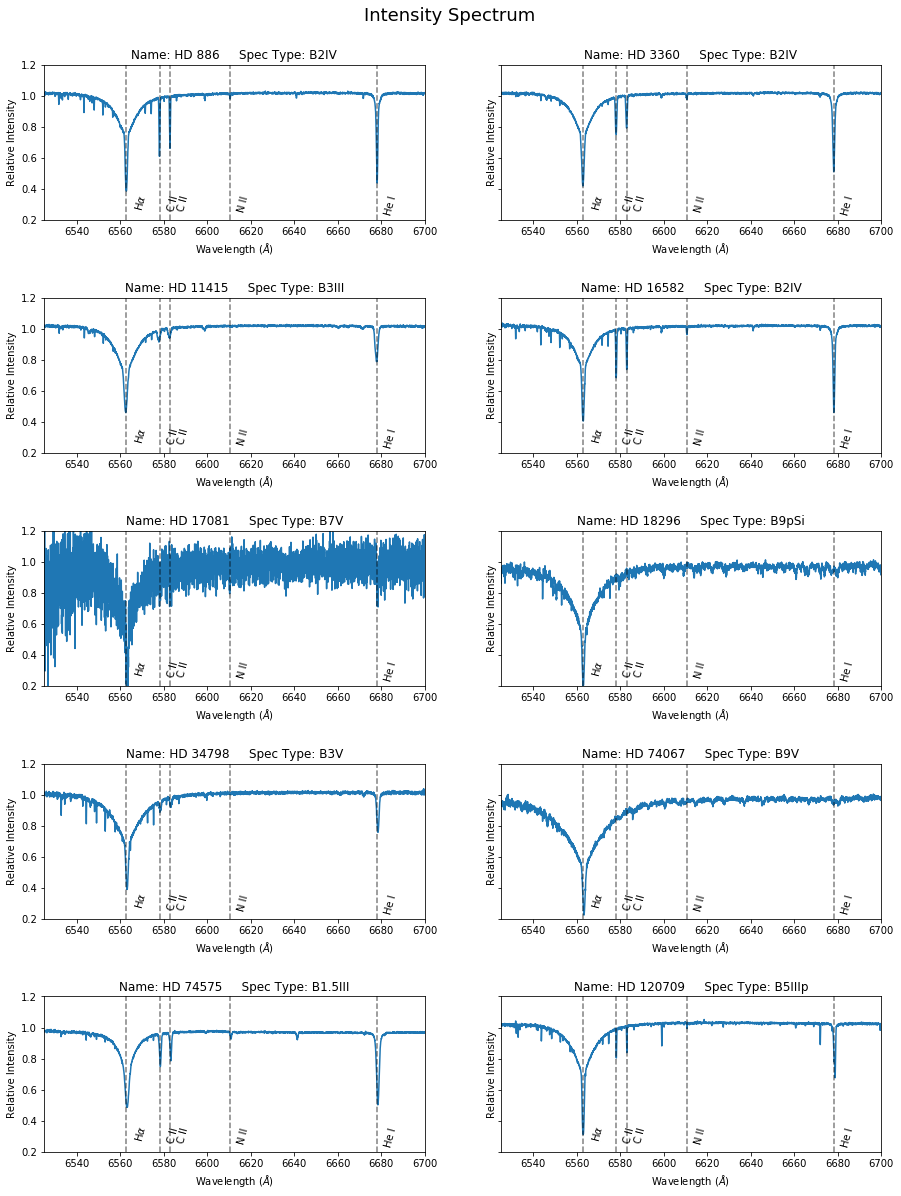

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

line_identifications = [(r'H$\alpha$', 6562.8), ('C II', 6578.05), ('C II', 6582.88),
                        ('N II', 6610.56), ('He I', 6678.1517)]


def plot_spectra(data_list, hd_list, sp_list):
    cols = 2
    rows = math.ceil(len(data_list) / cols)
    ylim = (0.2, 1.2)
    xlim = (6525, 6700)
    fig, axes = plt.subplots(rows,
                             cols,
                             figsize=(15, 20),
                             sharex=False,
                             sharey=True)
    plt.setp(axes, ylim=ylim, xlim=xlim)
    for data, hd_name, sp_type, ax in zip(data_list, hd_list, sp_list,
                                          axes.flatten()):
        ax.plot(data[0] * 10, data[1])

        for element, wavelength in line_identifications:
            ax.axvline(x=wavelength, c='black', ls='--', alpha=0.5)
            ax.text(wavelength + 3, ylim[0] + 0.11, element, rotation=75)

        ax.set_title('Name: HD {}     Spec Type: {}'.format(hd_name, sp_type))
        ax.set_xlabel(r'Wavelength ($\AA$)')
        ax.set_ylabel('Relative Intensity')

    fig.suptitle('Intensity Spectrum', y=0.92, fontsize=18)
    plt.subplots_adjust(hspace=0.5)
    plt.show()


nsubplots = 10
hd_list = unique_espadons_results['HD']
sp_list = unique_espadons_results['SpType']
plot_spectra(data_list[:nsubplots], hd_list[:nsubplots], sp_list[:nsubplots])